# Dataset Loader for spanish and japanese speech datasets
Based on:

* [Spanish Automatic Speech Recognition pytorch](https://www.kaggle.com/code/shwetanani/spanish-automatic-speech-recognition-pytorch/notebook#Test-the-Conv-GRU-Model)
* [120h Spanish Speech](https://www.kaggle.com/datasets/carlfm01/120h-spanish-speech)
* [Japanese Single Speaker Speech Dataset](https://www.kaggle.com/datasets/bryanpark/japanese-single-speaker-speech-dataset)

In [1]:
import IPython as ipd
import librosa
from utils import *

import torch
from torch.utils.data import IterableDataset

In [2]:
# Define source paths. Place data under working directory and name folder "voicedata"
BASE_PATH = "./"
DATA_PATH = BASE_PATH + "voicedata/"
TRANSCRIPT_PATH = DATA_PATH + "transcript.txt"

print(TRANSCRIPT_PATH)

./voicedata/transcript.txt


In [3]:
TOKENS = ",.!?-:;¡¿'"

def is_valid_sample(sample):
    if len(sample["path"]) == 0:
        return False
    if len(sample["utterance"]) == 0:
        return False
    if len(sample["label"]) == 0:
        return False
    return True

def process_sample(sample, word_list):
    result = sample
    
    # Remove all punctuation
    for token in TOKENS:
        result["label"] = result["label"].replace(token, "")

    # Make lower case
    result["label"] = result["label"].lower()

    # Remove sequential blanks from label
    result["label"] = " ".join([x for x in result["label"].split(" ") if len(x)])
    
    for word in result["label"].split(" "):
        word_list.add(word)

    return result

def make_dictionary(row):
    return {
        "path": DATA_PATH + row[0],
        "utterance": row[1],
        "label": row[2],
        "length": row[3]
           }

def calc_label_weight(label, words):
    result = torch.zeros(len(words))
    for word in label.split(" "):
        index = words.index(word)
#        result[index] += 1
    return result

In [4]:
class VoiceDataSet(IterableDataset):
    def __init__(self, base_path):
        self.base_path = base_path
        self.data_path = self.base_path + "voicedata/"
        self.transcript_path = self.data_path + "transcript.txt"
        print(f"VoiceDataSet: {self.data_path}")

        # Find all column cells in input transcript file
        words = set()
        rows = (l.strip() for l in open(TRANSCRIPT_PATH))
        columns = (l.split("|") for l in rows)

        # make an output dictionary of each row
        unprocessed = (make_dictionary(l) for l in columns if len(l) == 4)
        
        # Validate rows and fix labels, save labels to "words"
        self.samples = [process_sample(x, words) for x in unprocessed if is_valid_sample(x)]
        self.words = sorted(list(words))
        
        # Convert labels from 
        for sample in self.samples:
            sample["weight"] = calc_label_weight(sample["label"], self.words)

        errors = {x for x in self.words if not x.isalpha()}

        print(f'{len(self.samples)} samples found')
        print(f'{len(self.words)} words found')
        print(f'{len(errors)} error words found')

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        waveform, sample_rate = librosa.load(self.samples[idx]["path"])
        return waveform, sample_rate, self.samples[idx]["weight"]
    
    def __iter__(self):
        return (self.__getitem__(i) for i in enumerate(self.samples))

In [5]:
dataset = VoiceDataSet(BASE_PATH)

VoiceDataSet: ./voicedata/
11016 samples found
22298 words found
0 error words found


In [6]:
waveform, rate, label = dataset[9682]
print(label)
ipd.display.Audio(data=waveform, rate=rate)

tensor([0., 0., 0.,  ..., 0., 0., 0.])


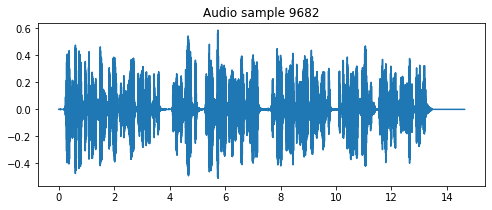

In [11]:
times = [s / rate for s in range(len(waveform))]
plot(times, waveform, title="Audio sample 9682")

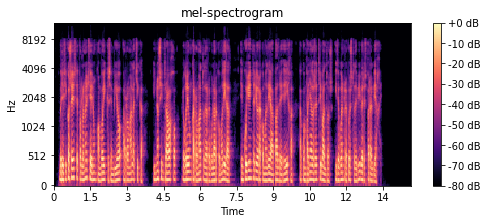

In [12]:
spectrogram = librosa.feature.melspectrogram(y=waveform, sr=rate)
plot_spectro(spectrogram, rate)